This Jupyter Notebook demonstrates the efficiency gains in lattice point generation within QMCPy achieved through parallel processing. 

Modified Date: Aug 21, 2023

Creation Date: Aug 21, 2023

In [1]:
import qmcpy as qp
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Define Functions 

In [3]:
def gen_points_iid(n, num_ports, seed=None):
    """ generating i.i.d. points """
    np.random.seed(seed)
    # Generate all points randomly from continuous uniform distribution in [0,1)
    points = np.random.random((num_ports, n))
    return points

def gen_points_sobol(n, num_ports, seed=None):
    """ generating randomized Sobol points """
    ld = qp.Sobol(n, seed=seed)  # define the generator
    points = ld.gen_samples(num_ports)  # generate points
    return points
    
def gen_points_lattice(n, num_ports, seed=None):
    """ generating randomized lattice points in serial fashion """
    l = qp.Lattice(dimension=n, seed=seed, is_parallel=False)
    points = l.gen_samples(num_ports) 
    return points
    
def gen_points_lattice_parallel(n, num_ports, seed=None):
    """ generating randomized lattice points in parallel fashion """
    l = qp.Lattice(dimension=n, seed=seed, order='mps', is_parallel=True)
    points = l.gen_samples(num_ports)  
    return points

## Change dimension $d$ and fix number of sampling points $2^n$

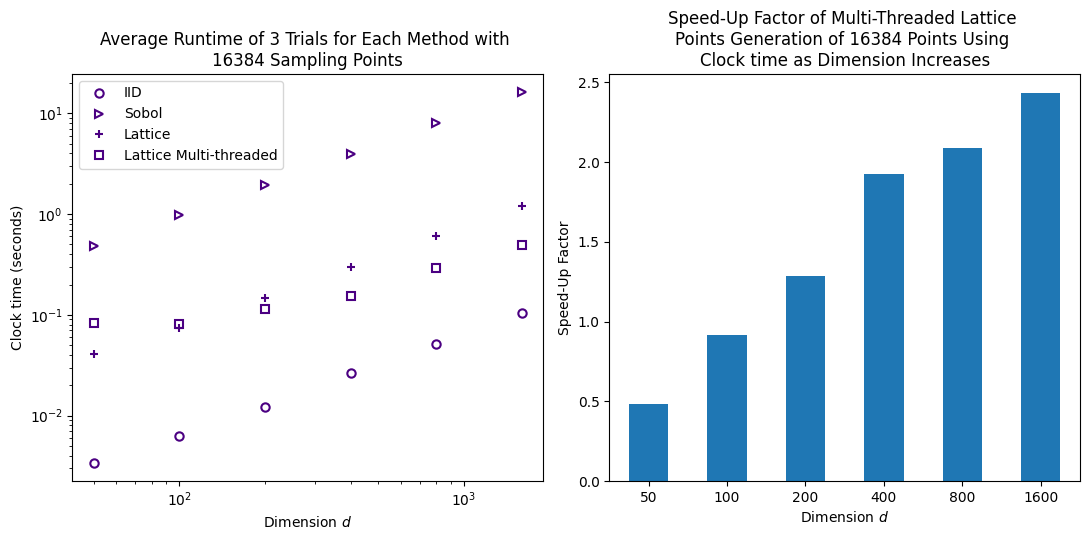

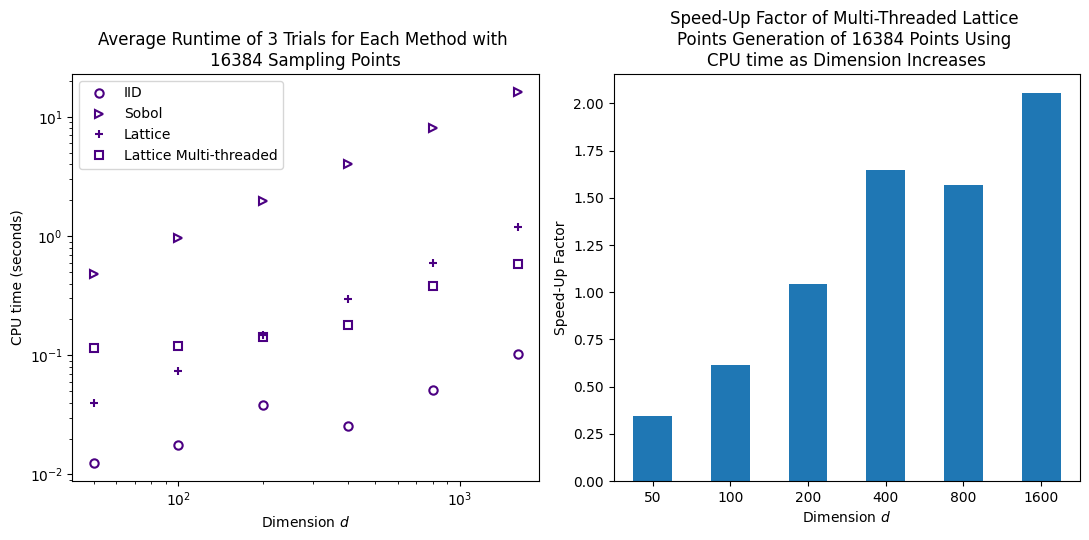

CPU times: user 3min 26s, sys: 8.95 s, total: 3min 35s
Wall time: 3min 32s


In [4]:
%%time

trials = 3
d_list = [50, 100, 200, 400, 800, 1600] 
n = 14
time_methods = [(time.time, 'Clock time'), (time.process_time, 'CPU time')]
time_output = {}

for time_method, time_method_name in time_methods:
    #######################################################
    # Measure execution time of each function
    ######################################################
    time_output[time_method_name] = {}

    # Create a new figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5.5))

    for method, method_name, marker in [
            (gen_points_iid, 'IID', 'o'),
            (gen_points_sobol, 'Sobol', '>'),
            (gen_points_lattice, 'Lattice', '+'),
            (gen_points_lattice_parallel, 'Lattice Multi-threaded', 's')]:

        ts = []

        for d in d_list:
            start_time = time_method()
            for _ in range(trials):
                _ = method(d, 2 ** n)
            end_time = time_method() - start_time
            ts.append(end_time / trials)

        time_output[time_method_name][method_name] = ts

        ax1.plot(d_list, ts, color='indigo', marker=marker,
                 linestyle='none', label=method_name,
                 markerfacecolor='none', markeredgewidth=1.5);

    ax1.set_title(f"Average Runtime of {trials} Trials for Each Method with \n{2 ** n} Sampling Points")
    ax1.set_xlabel("Dimension $d$")
    ax1.set_ylabel(f"{time_method_name} (seconds)")
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.legend()

    #######################################################
    # Compute lattice speed up by multithreading
    #######################################################
    x = time_output[time_method_name]['Lattice']
    y = time_output[time_method_name]['Lattice Multi-threaded']
    speedup = [xx / yy for xx, yy in zip(x, y)]
    df = pd.DataFrame({'d': d_list, 'speedup': speedup})

    df.plot.bar(x='d', y='speedup', rot=0, legend=None, ax=ax2);
    ax2.set_xlabel('Dimension $d$')
    ax2.set_ylabel('Speed-Up Factor')
    ax2.set_title(f'Speed-Up Factor of Multi-Threaded Lattice \nPoints Generation of {2 ** n} Points Using \n{time_method_name} as Dimension Increases')

    plt.tight_layout()
    plt.show();

Note that the speedup factor is not bigger than 1 when $d < 100$.

## Change number of sampling points $2^n$ and fix dimension $d$ 

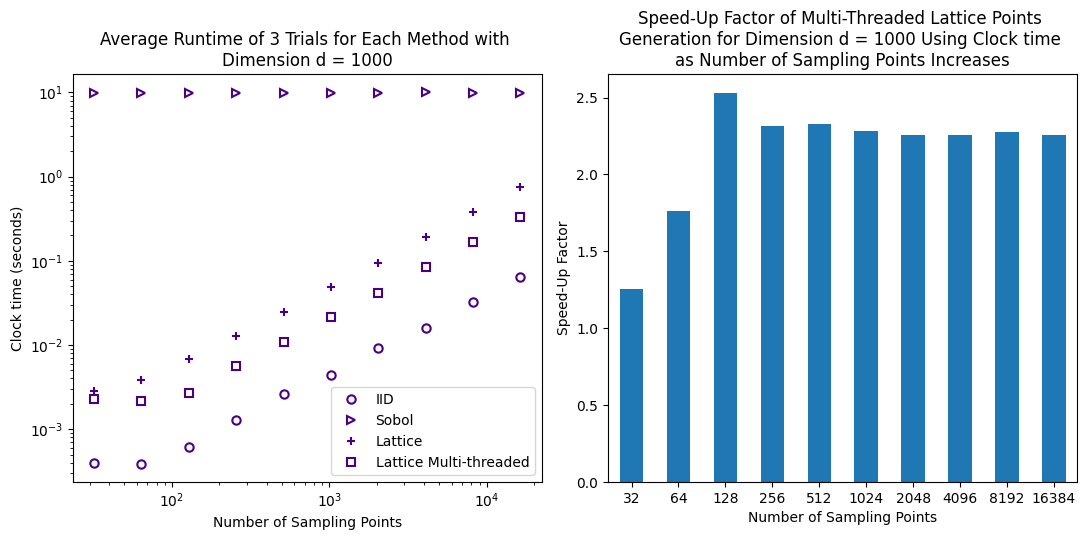

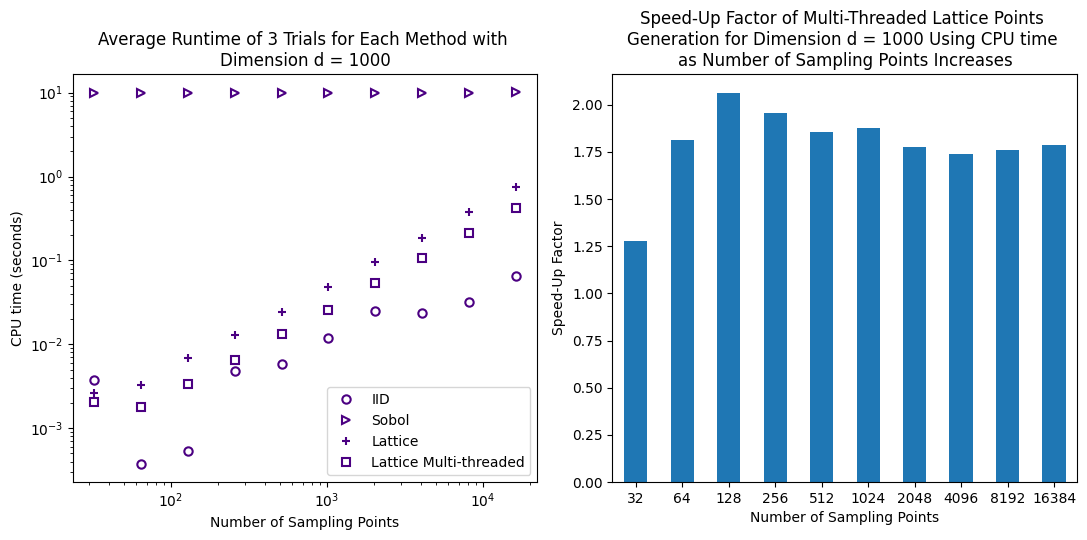

CPU times: user 10min, sys: 16.6 s, total: 10min 17s
Wall time: 10min 11s


In [7]:
%%time

ns = range(5, 15)
d = 1000
time_output = {}

for time_method, time_method_name in time_methods:
    #######################################################
    # Measure execution time of each function
    ######################################################
    
    # Create a new figure with 2 subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5.5))
    
    time_output[time_method_name] = {}
    for method, method_name, marker in \
            [(gen_points_iid, 'IID', 'o'),
             (gen_points_sobol, 'Sobol', '>'),
             (gen_points_lattice, 'Lattice', '+'),
             (gen_points_lattice_parallel, 'Lattice Multi-threaded', 's')]:
                
        ts = []
                
        for n in ns:
            start_time = time_method()
            for _ in range(0, trials):
                _ = method(d, 2 ** n)
            end_time = time_method() - start_time
            ts.append(end_time / trials)

        # Store the time outputs
        time_output[time_method_name] = {**time_output[time_method_name], method_name: ts}

        # Plot time for each method on the first subplot
        ax1.plot([2 ** n for n in ns], ts, color='indigo',
                      marker=marker, linestyle='none', label=method_name,
                      markerfacecolor='none', markeredgewidth=1.5)

    ax1.set_title(f"Average Runtime of {trials} Trials for Each Method with \nDimension {d = }")
    ax1.set_xlabel("Number of Sampling Points")
    ax1.set_ylabel(f"{time_method_name} (seconds)")
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.legend()

    #######################################################
    # Compute lattice speed up by multithreading
    #######################################################
    x = time_output[time_method_name]['Lattice']
    y = time_output[time_method_name]["Lattice Multi-threaded"]
    speedup = [xx / yy for xx, yy in zip(x, y)]
    df = pd.DataFrame({'Sampling Points': [2 ** n for n in ns], 'speedup': speedup})

    # Create a bar chart for speed up on the second subplot
    df.plot.bar(x='Sampling Points', y='speedup', rot=0, legend=None, ax=ax2)
    # Add labels and title
    ax2.set_xlabel('Number of Sampling Points')
    ax2.set_ylabel('Speed-Up Factor')
    ax2.set_title(f'Speed-Up Factor of Multi-Threaded Lattice Points \nGeneration for Dimension {d = } Using {time_method_name} \nas Number of Sampling Points Increases')

    # Adjust the layout of the subplots
    plt.tight_layout()
    plt.show();